# Component reliability, Part 2

<br><div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
<b>Task 0:</b>
Tasks to complete during the workshop are provided in boxes like this.
</p>
</div>
<br>
<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px;">
<p>
Explanations in the solution are provided in boxes like this.
</div>
<br>
<div style="background-color:#F9E076; vertical-align: middle; padding:3px 20px;">
<b>Note to students in offshore renewables or floating structures:</b> students in the dikes, dams and breakwaters unit have already done worked with this limit-state function and design scenario, so we encourage you to join a group of students from that unit!!! 
</div>
<br>
In this workshop, we will perform a reliability analysis of a hydraulic engineering problem: the reliability sea dike against wave overtopping. You can see videos of this process <a href="http://www.overtopping-manual.com/eurotop/videos-of-wave-overtopping/" target="_blank">here</a>! If the overtopping discharge is too great, or occurs for too long, the dike will erode and lead to flooding of the polder. This is not good, so we try and prevent it by making sure the probability of exceeding the overtopping capacity of the dike is small. We perform the analysis using the van der Meer equation, which calculates discharge [L/m/s] based on wave characteristics and freeboard, the vertical distance between the top of the dike and the still water level (the water level not considering waves).
<br>

The hydraulic boundary conditions are important for this calculation, because in coastal environments there are two main loads to consider: waves and wind setup. Waves are defined by their significant wave height and period, and are generated by a strong wind blowing over a large distance (the fetch). Wind setup occurs in shallow areas, where the wind "pushes" water up against the shore, causing an increase in the still water level. Both of these loads are dependent on the wind speed and water depth. We calculate waves using the Brettschneider equations, and setup using a simple 1D model. In summary the calculation process is as follows:

- estimate: dike crest height, average elevation of the sea bottom offshore of the dike (the foreshore), still water level due to tides
- estimate the wind speed, ideally using a probability distribution (extreme value!)
- calculate the wave conditions
- calculate the wind setup
- calculate the overtopping discharge

This has been implemented in the function `overtopping_discharge` in the attached file `utilities.py`. Some preliminary work has already been done for you by defining the design values for some of the parameters in the equations. Your task is to calculate and interpret the reliability of the dike against overtopping by setting up a MCS and FORM analysis using the following random variables:

| Variable | Name | Marginal distribution | Mean | c.o.v | 
| --- | --- | --- | --- | --- |
| $ob$ | Bottom elevation [m+NAP] | Normal | -2.0 | 0.15 |
| $h$ | Water surface elevation [m+NAP] | Normal | +2.0 | 0.10 |
| $u_{10}$ | Wind speed [m/s] | <code>WeibullMin</code> | 15.1 | 0.48 |

Note that you should define the WeibullMin distribution as <code>WeibullMin(17, 2.2)</code> using OpenTURNS (the inputs are the shape and scale parameters).the water surface elevation assumes a high tide situation, and the normal distribution represents the variability in high tide elevation observed throughout the year.

We know that there are two main hydraulic loads, caused by the wind, which govern overtopping discharge: wind setup and waves. Both of these are also dependent on the water depth, $d=h-ob$.The figure below illustrates the magnitude of each, as a function of the water depth for the 95th percentile wind speed.

![loads](./WS_03_figures/water_depth_loads.JPG "Effect of water depth on hydraulic loads.")

We can see that both effects have opposite relationships to water depth. Since both effects are also proportional to the overtopping discharge, it becomes difficult to establish what the "critical case" is to use in our dike design. Probabilistic methods can help us (by integrating across all combinations of loads), but in the end we still need to determine one set of design values which we will use to actually build the dike (in this case, freeboard). Finding an answer to this question and understanding the role of uncertainty in the solution is one of the main themes of this workshop.

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
<b>Task 1:</b>
There are at least two critical cases to consider for this problem. Imagine you are performing a deterministic analysis (but are still acknowledging that a few variables are random). List at least two design cases (qualitatively) and describe how you might select the load values to use in your overtopping calculation. Justify your decision.

</p>
<e>Hint: the design cases can be specified in terms of high or low values of wave height and setup, along with the associated water depth. The load values are the random variables, which should be described as percentiles.</e>
</div>

<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px;">
<p>
The two cases are: 1) large waves with smaller setup (deeper water), and 2) large setup with smaller waves (shallower water). The design loads should be selected based on the maximum allowable failure probability. If we need a failure probability of 0.001, we could choose the 90th percentile for each random variable (0.1$^3$=0.001).
    <br><br>
    There are two things to note here: 1) there are infinite combinations of design variable exceedance values that could lead to the same joint exceedance probability, and 2) if we can identify the most critical cases, we <e>might</e> get close to the actual failure probability. If we consider <e>all</e> failure cases and sum them up, we will asymptotically approach the real failure probability, i.e., integrating over the failure region! (caveat: this only works for joint exceedance cases; in other words, only load variables; for combinations of loads, we need to do FORM or MCS because they are capable of evaluating this more complicated failure region).
    <br><br>
We call this a 'semi-probabilistic' analysis because we use probability to derive the design values for one or more 'critical cases', but don't consider 'all' of the combinations (i.e., we don't integrate across the failure region!).
</div>

Now let's get our Python packages set up.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import fsolve # for plotting the LSF

The reliability analyses (FORM and MCS) will be performed using [OpenTURNS](https://openturns.github.io). Remember, there is a tutorial in the Probabilistic Design chapter of the HOS online textbook.

In [2]:
import openturns as ot
import openturns.viewer as viewer
ot.Log.Show(ot.Log.NONE)

We also have a few custom methods in `utilities.py`:

In [3]:
from utilities import *

In [4]:
overtopping_discharge?

Signature: overtopping_discharge(bottom, h, u10)
Docstring:
Calculate overtopping discharge from wave and freeboard

An empirical equation that is set up here to use the wave conditions from
bretschneider() function. Many variables are hard-coded in this function
for use in the HOS prob design unit exercise. Returns discharge as a
volumetric flow per unit length of dike.

EurOtop equation 5.10 & 5.11.

Arguments:
bottom: elevation of water body bottom [m + NAP]
h: elevation of water body surface [m + NAP]
u10: wind speed [m/s]

Returns:
qload: overtopping discharge [L/m/s]
File:      c:\users\rlanzafame\code\tudelft-citg\hos-prob-design\book\workshops\utilities.py
Type:      function


<br><div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
<b>Task 2:</b>
Define the three random variables as OpenTURNS distributions, then check whether you can evaluate the limit-state function properly by evaluating the overtopping discharge at the 90th percentile value of each random variable. Based only on this calculation, what do you think the probability of exceedance is for this overtopping discharge?

</p>
<e>Hint: think about the exceedance probability of each random variable and the dependence between them.</e>
</div>

In [5]:
u10 = ot.WeibullMin(17, 2.2)
ob = ot.Normal(-2, 0.3)
h = ot.Normal(2, 0.2)
q_result = overtopping_discharge(ob.computeInverseSurvivalFunction(.1)[0],
                                 h.computeInverseSurvivalFunction(.1)[0],
                                 u10.computeInverseSurvivalFunction(.1)[0])
print('Discharge computed with 10% probability of exceedance for each RV:\n',
      f'    q = {q_result:0.2e} [L/m/s]')

Discharge computed with 10% probability of exceedance for each RV:
     q = 2.56e-03 [L/m/s]


<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px;">
<br>
    
The solution is in the code cell above. Regarding the exceedance probability: it is reasonable to assume that the three random variables are independent, since they don't really have any physical relationship with each other. Therefore the probability of exceeding this overtopping discharge can be estimated as $0.1^3=0.001$. It may surprise you that the discharge is small. That's ok, because it's only one case...if we looked at *all* cases, we would see larger discharge values (more rare combinations of loads) and that the summing of them together starts to approach the failure probability calculated below.
    
</div>

<br>

<br><div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
<b>Task 3:</b>
Define the limit-state function (incorporating the maximum allowable discharge of $q=1$ [L/m/s]), multivariate probability distribution and set up the OpenTURNS analysis and solve the reliability problem using MCS and FORM.
</p>
</div>

<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px;">
<p>
The solution is in the code cell below.
</div>

In [19]:
def myLSF(x):
    ''' 
    Vectorized limit-state function.

    Arguments:
    x: vector. x=[u10, ob, h]. 
    '''
    q_max = 1
    g = [q_max - overtopping_discharge(x[0], x[1], x[2])]
    return g

# Definition of the dependence structure: here, multivariate normal with correlation coefficient rho between two RV's.
R = ot.CorrelationMatrix(3)   
multinorm_copula = ot.NormalCopula(R)

inputDistribution = ot.ComposedDistribution((ob, h, u10), multinorm_copula)
inputDistribution.setDescription(["ob", "h", "u_10"])
inputRandomVector = ot.RandomVector(inputDistribution)

myfunction = ot.PythonFunction(3, 1, myLSF)

# Vector obtained by applying limit state function to X1 and X2
outputvector = ot.CompositeRandomVector(myfunction, inputRandomVector)

# Define failure event: here when the limit state function takes negative values
failureevent = ot.ThresholdEvent(outputvector, ot.Less(), 0)
failureevent.setName('LSF inferior to 0')

optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(100000)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

# Starting point for FORM
start_pt = []

algo = ot.FORM(optimAlgo, failureevent, inputDistribution.getMean())  # Maybe change 3rd argument and put start_pt defined above
algo.run()
result = algo.getResult()
x_star = result.getPhysicalSpaceDesignPoint()        # Design point: original space
u_star = result.getStandardSpaceDesignPoint()        # Design point: standard normal space
pf = result.getEventProbability()                    # Failure probability
beta = result.getHasoferReliabilityIndex()           # Reliability index
print('FORM result, pf = {:.4f}'.format(pf))
print('FORM result, beta = {:.3f}\n'.format(beta))
print('The design point in the u space: ', u_star)
print('The design point in the x space: ', x_star)

montecarlosize = 10000
outputSample = outputvector.getSample(montecarlosize)

number_failures = sum(i < 0 for i in np.array(outputSample))[0]      # Count the failures, i.e the samples for which g(x)<0
pf_mc = number_failures/montecarlosize                               # Calculate the failure probability                       

print('pf for MCS: ', pf_mc)

FORM result, pf = 0.0185
FORM result, beta = 2.086

The design point in the u space:  [0.111151,0.127742,2.07923]
The design point in the x space:  [-1.96665,2.02555,31.8292]
pf for MCS:  0.0202


<br><div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
<b>Task 4:</b>
Interpret the reliability analyses. Be sure to consider: pf, beta, the design point in the x and u space, linearity of the limit-state function, importance and sensitivity.
</p>
</div>

<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px;">
<p>
Let's first print and calculate a few of the additional results:
</div>

### Importance factors

As presented in the lecture, the importance factors are useful to rank each variable's contribution to the realization of the event. 

OpenTURNS offers built-in methods to compute the importance factors and display them:

[ob : 0.0028389, h : 0.00374968, u_10 : 0.993411]


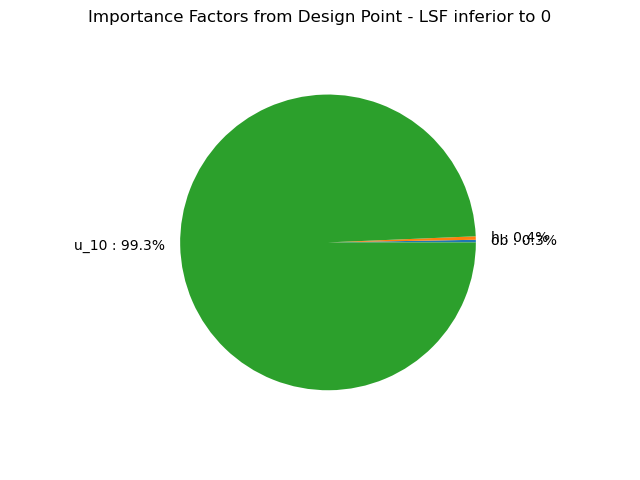

In [7]:
alpha_ot = result.getImportanceFactors()
print(alpha_ot)
result.drawImportanceFactors()

We also compute the importance factors as they are defined in your textbook in order to compare them. 

In [8]:
alpha = u_star/beta
print("The importance factors as defined in the textbook are: ", alpha)

The importance factors as defined in the textbook are:  [0.0532813,0.0612346,0.9967]


### Sensitivity factors

We can also access the sensitivity of the reliability index $\beta$ with regards to the distribution parameters with the built-in method:

In [9]:
sens = result.getHasoferReliabilityIndexSensitivity()
print("The sensitivity factors of the reliability index "
      "with regards to the distribution parameters are:\n")
for i in range(sens.getSize()):
    print(sens.at(i))

The sensitivity factors of the reliability index with regards to the distribution parameters are:

[mean_0_marginal_0 : -0.177604, standard_deviation_0_marginal_0 : -0.0197409]
[mean_0_marginal_1 : -0.306173, standard_deviation_0_marginal_1 : -0.0391113]
[beta_marginal_2 : -0.209769, alpha_marginal_2 : 1.0166, gamma_marginal_2 : -0.112038]
[R_2_1_copula : 0, R_3_1_copula : 0, R_3_2_copula : 0]


<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px;">
From the results printed above:
<ul>
    <li>The wind speed is by far the most important random variable!</li>
    <li>The design point in the u space is [0.11,0.13,2.08]. This indicates a most 'extreme' value for u10, and that it's around the 97th percentile (the others are around 55th)---that's around 0.006.</li>
    <li>The linearized limt-state function does not produce a pf significantly different than MCS (but see graphical interpretation below). </li>
</ul>
</div>

## Graphical Interpretation

In [41]:
def plot_contour(dis, xlim=(-3, -1), ylim=(1,3), ax=None): 
    ''' Note: x is a row vector of 2 elements: x[0] is first axis, x[1] second. '''  
    if ax is None:
        f, ax = plt.subplots(1)
    else: 
         f = plt.gcf()         

    x_axis = np.linspace(xlim[0], xlim[1], 100)
    y_axis = np.linspace(ylim[0], ylim[1], 100)
    # Contour plot
    X_grid,Y_grid = np.meshgrid(x_axis, y_axis)
    pdf = np.zeros(X_grid.shape)
    for i in range(X_grid.shape[0]):
        for j in range(X_grid.shape[1]):
                pdf[i,j] = dis.computePDF([X_grid[i,j], Y_grid[i,j], x_star[2]]) # Change this
    ax.contour(X_grid, Y_grid, pdf, levels=8, cmap=cm.Blues)

    ax.set_xlabel("ob", fontsize=14)  # Change labels and title
    ax.set_ylabel("h", fontsize=14)     # CHange label
    ax.plot(x_star[0], x_star[1], 'ro', label="Design point")    # Adapt this to rest of WS
    
    y_ls = [h.getMean()[0]]
    
    for k in x_axis:
        temp_func = lambda h: myLSF(np.array([k, h, x_star[2]]))[0]
        y_ls.append(fsolve(temp_func, y_ls[-1])[0]) 
    
    y_ls.pop(0)

    # ylim = ax.get_ylim()
    ax.plot(x_axis, y_ls, color="k", label="LSF")
    ax.fill_between(x_axis, y_ls, ylim[1], color="grey", label="Failure region")
    ax.set_title(r"Limit state function in the plane $(ob, h)$", fontsize=18)    # CHange title
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend()
    return None

def p_or(dis, x):
    ''' Computes the probability P(X1>x1 OR X1>x2). 
    
    Parameters:
    dis : OT ComposedDistribution
    x: 1D vector. First and second coordinates contain values of x1 and x2, respectively. 
    '''
    return 1 - dis.computeCDF(x)

def p_and(dis, x):
    ''' Computes the probability P(X1>x1 AND X1>x2). 
    
    Parameters:
    dis : OT ComposedDistribution
    x: 1D vector. First and second coordinates contain values of x1 and x2, respectively. 
    '''
    X1 = dis.getMarginal(0)
    X2 = dis.getMarginal(1)
    p = 1 - X1.computeCDF(x[0]) - X2.computeCDF(x[1]) + dis.computeCDF(x)
    return p

def plot_and(dis, x, ax=None, contour=False, xlim=(-3, -1), ylim=(1,3)):
    """ Computes the probability P(X>x,Y>y) and draws the related figure. """
    if ax is None:
        f, ax = plt.subplots(1)
    else :
        f = plt.gcf()
    if contour:
        plot_contour(dis, ax=ax, xlim=xlim, ylim=ylim)
    if xlim is None:
        xlim = ()   # Complete with default limits
    if ylim is None:
        ylim = ()    # Complete with default limits
    
    ax.vlines(x[0], ymin=ylim[0], ymax=ylim[1], colors='k', linestyles="dashed")
    ax.hlines(x[1], xmin=xlim[0], xmax=xlim[1], colors='k', linestyles="dashed")
    ax.vlines(x[0], ymin=ylim[0], ymax=ylim[1], colors='k', linestyles="dashed")
    ax.hlines(x[1], xmin=xlim[0], xmax=xlim[1], colors='k', linestyles="dashed")
    ax.fill_between([x[0], xlim[1]], x[1], ylim[1], color="lightgrey", linewidth=2, edgecolor="k", alpha=1, zorder=0)
    ax.axis("scaled")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    p = p_and(dis, [x[0], x[1], x_star[2]])
    ax.set_title("$p_{AND}$")
    if p<0.01:
        ax.text(.01, .01, r"$(P=$" + "{:.2e})".format(p), ha="left", va="bottom", transform=ax.transAxes)
    else: 
        ax.text(.01, .01, r"$(P=$" + "{:.4f})".format(p), ha="left", va="bottom", transform=ax.transAxes)
    ax.set_xlabel("ob")  
    ax.set_ylabel("h")   
    return f, ax

def plot_or(dis, x, ax=None, contour=False, xlim=(-3,-1), ylim=(1,3)):
    """ Computes the probability P(X>x OR Y>y) and draws the related figure. """
    if ax is None:
        f, ax = plt.subplots(1)
    else :
        f = plt.gcf()
    if contour:
        plot_contour(dis, ax=ax, xlim=xlim, ylim=ylim)
    if xlim is None:
        xlim = ()   # Complete
    if ylim is None:
        ylim = ()   # Complete

    ax.vlines(x[0], ymin=x[1], ymax=ylim[1], colors='k', linestyles="dashed")
    ax.hlines(x[1], xmin=x[0], xmax=xlim[1], colors='k', linestyles="dashed")
    ax.fill_between(np.array([xlim[0], x[0], x[0], xlim[1]]), np.array([x[1], x[1], ylim[0], ylim[0]]), ylim[1], color='lightgrey', linewidth=2, edgecolor="k", zorder=0) 
    # ax.axvspan(xlim[0],xlim[1],ylim[0],ylim[1], edgecolor="k", linewidth=4, facecolor="None", zorder=zorder+1)
    ax.axis("scaled")
    p = p_or(dis, [x[0], x[1], x_star[2]])
    ax.set_title("$p_{OR}$")
    if p<0.01:
        ax.text(.01, .01, r"$(P=$" + "{:.2e})".format(p), ha="left", va="bottom", transform=ax.transAxes)
    else: 
        ax.text(.01, .01, r"$(P=$" + "{:.4f})".format(p), ha="left", va="bottom", transform=ax.transAxes)
    ax.set_xlabel("ob")   # Change
    ax.set_ylabel("h")   # Change
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    return f, ax

C:\Users\rlanzafame\AppData\Local\Temp\ipykernel_15544\2050744889.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  temp_func = lambda h: myLSF(np.array([k, h, x_star[2]]))[0]


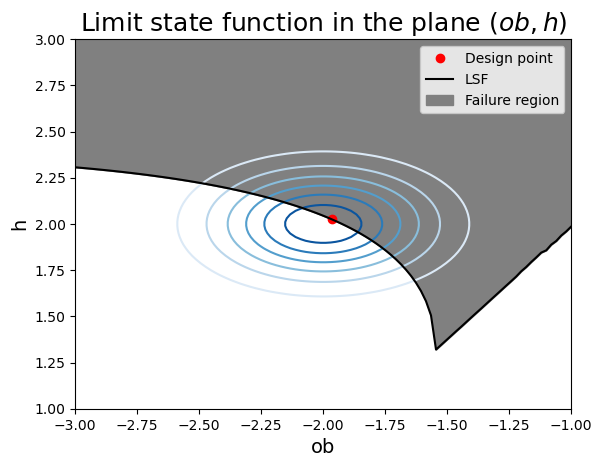

In [42]:
plot_contour(inputDistribution)

<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px;">
From the figure above:
<ul>
    <li>The limit state is highly non-linear. The reason FORM is still not a bad approximation compared to MCS is because most of the probability density contribution comes from the "missing" variable in this plot: the wind speed, which has the highest importance.</li>
    <li>It looks like the calculated failure probability would not change much if the design point were located at different points along the limit-state surface. This is interesting because it gives insight into our Task 1. If lines of constant water depth were plotted here, they would be parallel lines going from bottom-left to top right; the value of d for each line would be increaseing from lower-right to upper-left. This means that our high wave/low setup condition is in the upper-left, and the high setup/low wave condition is in the lower right. And each of them have probabilities that may be similar, thus it indicates our semi-probabilistic approach should consider both combinations!</li>
    <li>The limit-state function has a very strange shape on the right side of the figure. This is due to the implementation of the overtopping calculation, where small values are cut off. Luckily it does not impact the result because it is in an area of the failure region with negligible probability density.</li>
</ul>
</div>